In [3]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d

from textblob.sentiments import NaiveBayesAnalyzer
from textblob import TextBlob

In [4]:
input_directory = '/Users/zahra/git/loris_ai_data_challenge/data'

conversations_text = 'dialogues_text.txt'
conversations_emotion = 'dialogues_emotion.txt'
conversations_topic = 'dialogues_topic.txt'
conversations_action = 'dialogues_act.txt'

topic_dict = {'1': 'Ordinary Life', '2': 'School Life', '3': 'Culture_Education',
              '4': 'Attitude_Emotion', '5': 'Relationship', '6': 'Tourism' , '7': 'Health', 
              '8': 'Work', '9': 'Politics', '10': 'Finance'}

action_dict = {'1': 'inform', '2': 'question', '3': 'directive', '4': 'commissive'}
    

In [6]:
def convert_topic(topic):
    return topic_dict[topic]

In [7]:
def convert_action(act):
    return action_dict[act]

In [8]:
def load_conversations():
        
    dial_dir = os.path.join(input_directory, conversations_text)
    emo_dir = os.path.join(input_directory, conversations_emotion)
    act_dir = os.path.join(input_directory, conversations_action)
    topic_dir = os.path.join(input_directory, conversations_topic)
    
    # Open files
    in_dial = open(dial_dir, 'r')
    in_emo = open(emo_dir, 'r')
    in_act = open(act_dir, 'r')
    in_topic = open(topic_dir, 'r')
    
    # build a list of dictionaries: a dictionary per dialogue
    conversations_list = [
        {
            'utterances': utterances,
            'emotions': emotions,
            'actions': actions,
            'topic': convert_topic(topic)
        }
        for utterances, emotions, actions, topic in (
            (dialogue.split('__eou__')[:-1], 
             emotion.split(), 
             action.split(), 
             topic.strip())
            for dialogue, emotion, action, topic in zip(in_dial, in_emo, in_act, in_topic)
        )
        if len(utterances) == len(emotions) == len(actions)
    ]
            
    return conversations_list

In [9]:
def find_sentiment(conversation_dict):
    
    conversation_text = conversation_dict['utterances']
    conversation_emotion = [int(elem) for elem in conversation_dict['emotions']]
    conversation_emotion_blob = []
    
    for sentence in conversation_text:
        blob = TextBlob(sentence)
        conversation_emotion_blob.append(blob.sentiment.polarity)
    conversation_dict['blob_emotions'] = conversation_emotion_blob
    

In [10]:
def find_sentiments_for_all(conversations_list):
    
    for conversation_dict in conversations_list:
        find_sentiment(conversation_dict)
        first_speaker, second_speaker = conversation_dict['blob_emotions'][::2], conversation_dict['blob_emotions'][1::2] 
        conversation_dict['change_in_emotions'] = max(abs(first_speaker[0]-first_speaker[-1]), 
                                                         abs(second_speaker[0]-second_speaker[-1]))


In [11]:
def find_actions_proportion(conversation_list):
    
    for conversation_dict in conversation_list:
        
        actions_list = conversation_dict['actions']
        for key, value in action_dict.items():
            conversation_dict['prop_'+value] = actions_list.count(key)/len(actions_list)


In [12]:
def plot_emotions(first_speaker_emotions, second_speaker_emotions):
    plt.figure(figsize=(10, 4))
    
    xnew = np.linspace(0, len(first_speaker_emotions), num=10, endpoint=True)
    smooth_fun = interp1d(range(len(first_speaker_emotions)), first_speaker_emotions,
                  kind='quadratic', fill_value="extrapolate")
    
    plt.subplot(1, 2, 1)
    plt.plot(xnew, smooth_fun(xnew))
    plt.ylabel('Emotion Value')
    plt.xlabel('Time')
    plt.ylim((-1, +1))
    plt.axhline(0, color='black', ls='--')
    plt.title('First speaker\'s Emotions vs. Time')

    xnew = np.linspace(0, len(second_speaker_emotions), num=10, endpoint=True)
    smooth_fun = interp1d(range(len(second_speaker_emotions)), second_speaker_emotions,
                  kind='quadratic', fill_value="extrapolate")

    plt.subplot(1, 2, 2)
    plt.plot(xnew, smooth_fun(xnew))
    plt.ylabel('Emotion Value')
    plt.xlabel('Time')
    plt.ylim((-1, +1))
    plt.axhline(0, color='black', ls='--')
    plt.title('Second speaker\'s Emotions vs. Time')
    plt.show()

In [13]:
def find_max(conversations_list, topn=5):
    
    emotions_df = pd.DataFrame(conversations_list)
    largest_change = emotions_df.nlargest(topn, 'change_in_emotions', keep='first')
    
    for index, row in largest_change.iterrows():
        print(index, row)
        row_dict = row.to_dict()
        plot_emotions(row_dict['blob_emotions'][::2], row_dict['blob_emotions'][1::2])
     

In [14]:
def plot_change_emotions_vs_topics(conversations_list):
    
    emotions_df = pd.DataFrame(conversations_list)
    sns.boxplot(y='topic', x='change_in_emotions', data=emotions_df)
    plt.show()

In [15]:
def plot_end_emotions_vs_topic(conversations_list):
    
    emotions_df = pd.DataFrame(conversations_list)
    emotions_df['last_emotion'] = [emotions[-1] for emotions in emotions_df['blob_emotions']]
    emotions_df['start_emotion'] = [emotions[0] for emotions in emotions_df['blob_emotions']]
    
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(y='topic', x='last_emotion', data=emotions_df)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y='topic', x='start_emotion', data=emotions_df)
    plt.show()

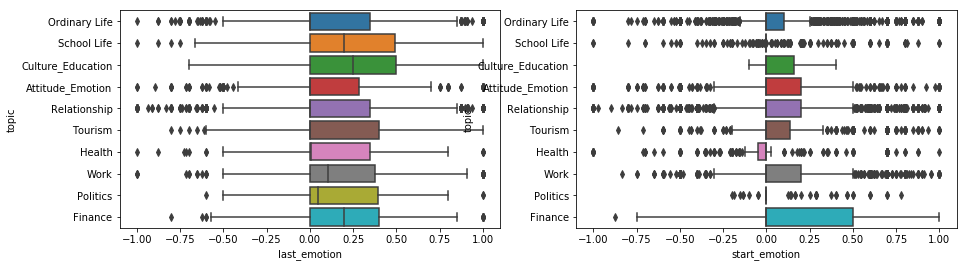

In [105]:
plot_end_emotions_vs_topic(conversations_list)

In [24]:
conversations_list = load_conversations()
print(len(conversations_list))

13117


In [17]:
find_sentiments_for_all(conversations_list)

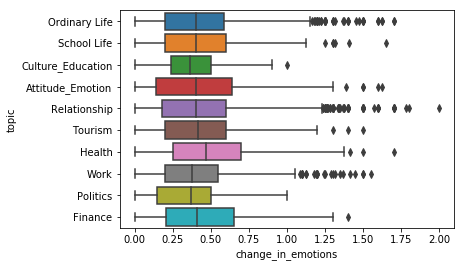

In [76]:
plot_change_emotions_vs_topics(conversations_list)

7483 actions                                        [2, 1, 2, 2, 2, 1, 2, 1]
blob_emotions         [-1.0, 0.0, -0.3125, 0.0625, -0.3125, 0.2, 1.0...
change_in_emotions                                                    2
emotions                                       [0, 0, 0, 0, 0, 0, 0, 0]
prop_commissive                                                       0
prop_directive                                                        0
prop_inform                                                       0.375
prop_question                                                     0.625
topic                                                      Relationship
utterances            [What's the matter with you , then ? You look ...
Name: 7483, dtype: object


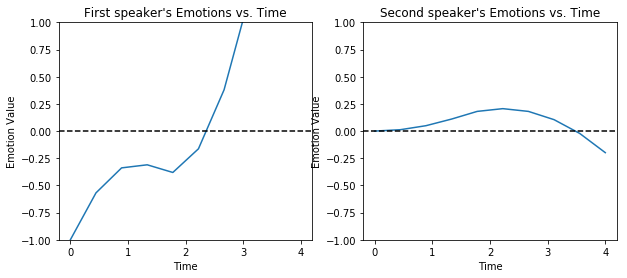

5608 actions                            [1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 4, 2]
blob_emotions         [-1.0, 0.0, 0.0, 0.5, 0.0, -0.0499999999999999...
change_in_emotions                                                  1.8
emotions                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4]
prop_commissive                                               0.0833333
prop_directive                                                0.0833333
prop_inform                                                         0.5
prop_question                                                  0.333333
topic                                                      Relationship
utterances            [The weather is terrible . ,  Yeah . It's been...
Name: 5608, dtype: object


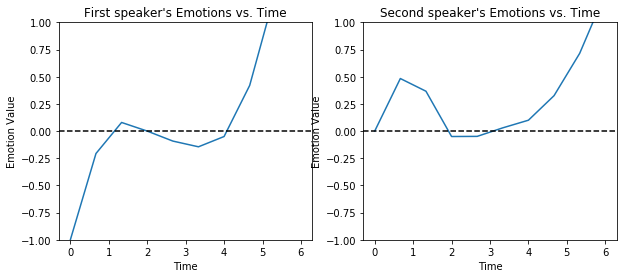

8015 actions                                              [1, 1, 2, 1, 2, 1]
blob_emotions         [0.5392857142857143, -0.78125, 0.0, 0.0, 0.0, ...
change_in_emotions                                              1.78125
emotions                                             [0, 0, 0, 0, 0, 0]
prop_commissive                                                       0
prop_directive                                                        0
prop_inform                                                    0.666667
prop_question                                                  0.333333
topic                                                      Relationship
utterances            [I'll tell you something that's good about act...
Name: 8015, dtype: object


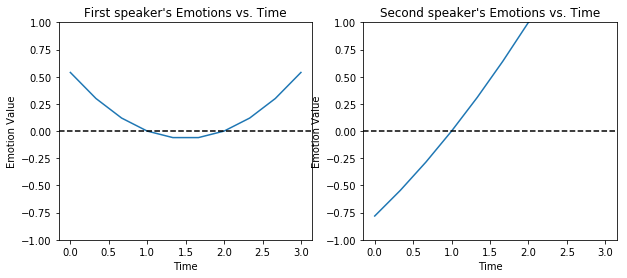

5630 actions                                     [1, 1, 1, 1, 2, 2, 1, 3, 4]
blob_emotions         [-1.0, 0.16944444444444443, -0.2, 0.5, 0.0, 0....
change_in_emotions                                                  1.7
emotions                                    [0, 0, 0, 0, 0, 0, 4, 4, 4]
prop_commissive                                                0.111111
prop_directive                                                 0.111111
prop_inform                                                    0.555556
prop_question                                                  0.222222
topic                                                      Relationship
utterances            [The weather is terrible . ,  Yes . It was sun...
Name: 5630, dtype: object


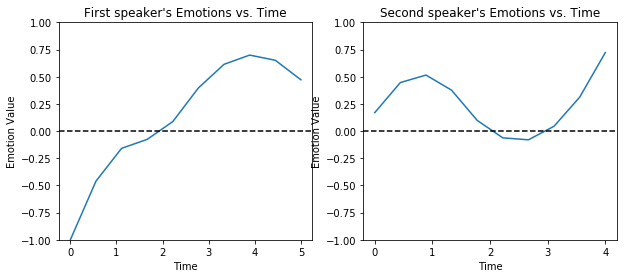

5799 actions                                              [2, 2, 1, 1, 1, 1]
blob_emotions         [-1.0, 0.7, 0.34375, -0.2916666666666667, 0.7,...
change_in_emotions                                                  1.7
emotions                                             [0, 0, 0, 0, 0, 0]
prop_commissive                                                       0
prop_directive                                                        0
prop_inform                                                    0.666667
prop_question                                                  0.333333
topic                                                      Relationship
utterances            [My boss wore a real stupid tie to work today ...
Name: 5799, dtype: object


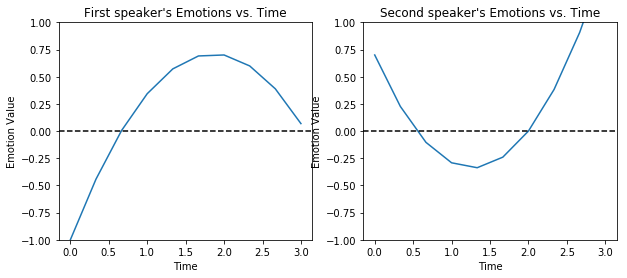

In [77]:
find_max(conversations_list)

In [32]:
find_actions_proportion(conversations_list)

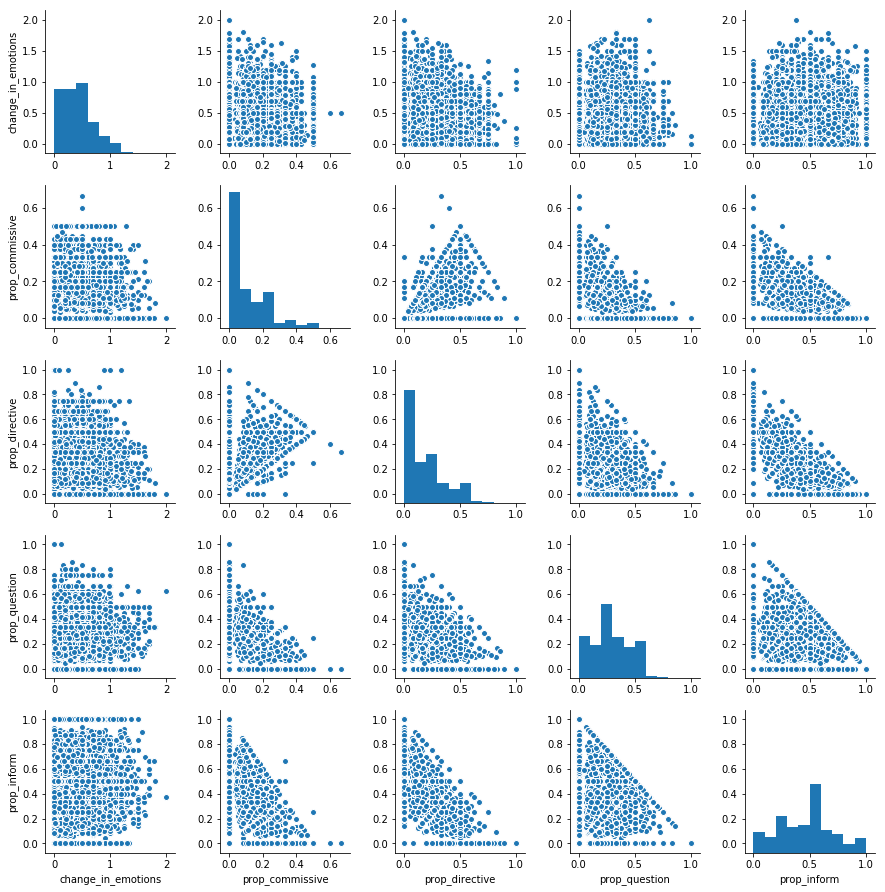

In [33]:
emotions_df = pd.DataFrame(conversations_list)
sns.pairplot(data=emotions_df[['change_in_emotions', 'prop_commissive', 
                               'prop_directive', 'prop_question', 'prop_inform']], 
             kind="scatter")
plt.show()

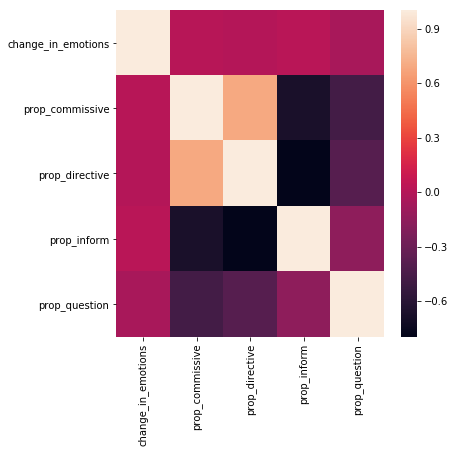

In [79]:
corr = emotions_df.corr()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.show()

In [23]:
emotions_df = pd.DataFrame(conversations_list)
emotions_df['num_uttrances'] = [len(utterances) for utterances in emotions_df['utterances']]
print(emotions_df['num_uttrances'].sum())

102968
